<a href="https://colab.research.google.com/github/variable-jain/Deep-learning-experiments-with-pytorch-and-fastai/blob/main/Improving_the_image_model_training_Data_augmentation_and_training_time_tricks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training a Pet classifier
> Baseline model

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastai.vision.all import *
from fastbook import *
matplotlib.rc('image', cmap='Greys')

In [ ]:
path = untar_data(URLs.PETS)

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [ ]:
(path/'images').ls()

(#7393) [Path('images/german_shorthaired_141.jpg'),Path('images/samoyed_55.jpg'),Path('images/german_shorthaired_26.jpg'),Path('images/yorkshire_terrier_119.jpg'),Path('images/miniature_pinscher_83.jpg'),Path('images/staffordshire_bull_terrier_176.jpg'),Path('images/Persian_21.jpg'),Path('images/basset_hound_90.jpg'),Path('images/Siamese_184.jpg'),Path('images/chihuahua_65.jpg')...]

In [ ]:
pets = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)
dls = pets.dataloaders(path/'images')

Following are two methods to cross-check if your DataBlock and DataLoader is working as expected

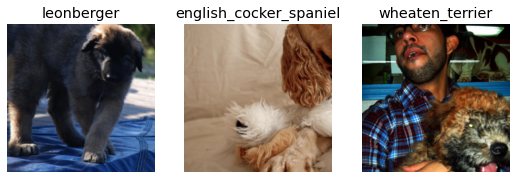

In [ ]:
dls.show_batch(nrows=1, ncols=3)

In [ ]:
pets.summary(path/'images')

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_143.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=332x500
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_143.jpg
    applying partial gives
      Maine_Coon
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=332x500, TensorCategory(6))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.498990,0.337902,0.110284,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.512171,0.284915,0.090663,01:11
1,0.333264,0.198404,0.063599,01:11


# Model Interpretation

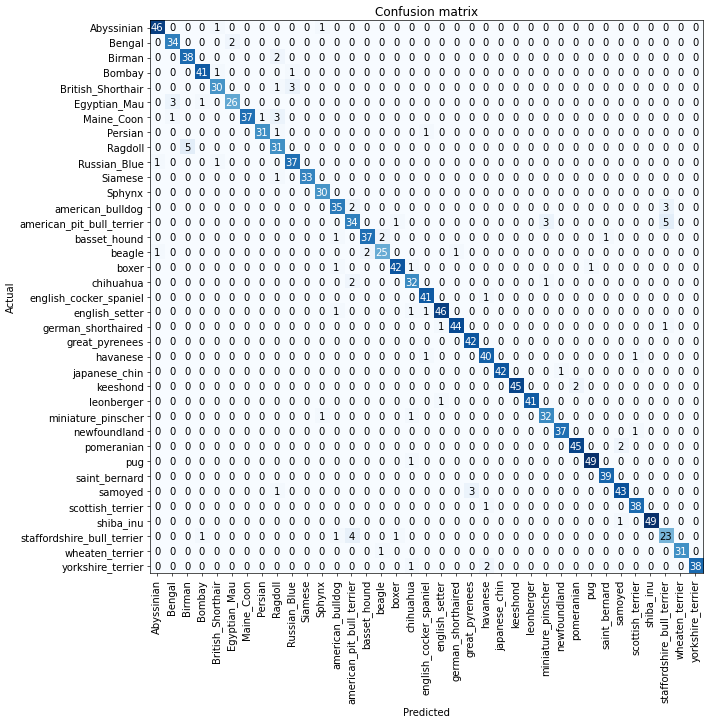

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=3)

[('Ragdoll', 'Birman', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Egyptian_Mau', 'Bengal', 3),
 ('Maine_Coon', 'Ragdoll', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('american_pit_bull_terrier', 'miniature_pinscher', 3),
 ('samoyed', 'great_pyrenees', 3)]

# Improving our model

## Learning rate tuning

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.664019,3.780021,0.394452,01:06


epoch,train_loss,valid_loss,error_rate,time
0,4.045126,4.319509,0.696211,01:10


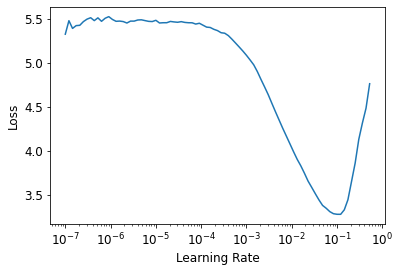

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep = learn.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min/10:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.20e-03, steepest point: 3.02e-03


In [24]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.298566,0.339015,0.111637,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.530092,0.374208,0.113667,01:11
1,0.331351,0.241762,0.071719,01:12


## Unfreezing and Transfer learning

In [25]:
learn.fine_tune??

In [27]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.147443,0.319863,0.095399,01:07
1,0.539759,0.248597,0.079161,01:07
2,0.322873,0.202780,0.064953,01:07


In [28]:
learn.unfreeze()

SuggestedLRs(lr_min=3.6307807022240014e-06, lr_steep=6.309573450380412e-07)

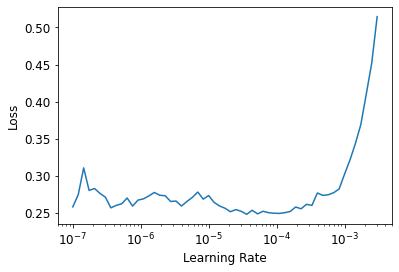

In [29]:
learn.lr_find()

In [30]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.252887,0.190853,0.061570,01:13
1,0.246898,0.186063,0.060217,01:14
2,0.220638,0.188173,0.061570,01:13
3,0.209496,0.186353,0.062923,01:14
4,0.187859,0.181572,0.058863,01:13
5,0.184234,0.182338,0.058187,01:13


**We can also use a slice of learning rates**

In [31]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.147228,0.359171,0.108254,01:07
1,0.556492,0.254682,0.080514,01:07
2,0.347981,0.211694,0.070365,01:07


epoch,train_loss,valid_loss,error_rate,time
0,0.274183,0.209086,0.072395,01:12
1,0.246540,0.202751,0.067659,01:12
2,0.246537,0.204471,0.067659,01:12
3,0.216056,0.196037,0.065629,01:12
4,0.203830,0.182003,0.058187,01:11
5,0.178449,0.183385,0.059540,01:11
6,0.156040,0.187344,0.062246,01:12
7,0.147985,0.183480,0.055480,01:12
8,0.136769,0.184261,0.054804,01:11
9,0.126025,0.179531,0.056834,01:12


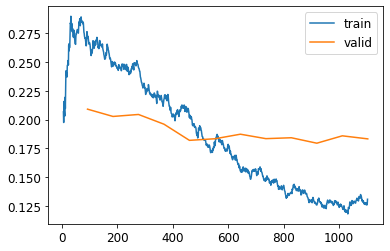

In [32]:
learn.recorder.plot_loss()

## Training a deeper model

In [33]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.286575,0.305524,0.098782,01:06
1,0.577931,0.273323,0.089310,01:06
2,0.433882,0.279130,0.092016,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.286315,0.240809,0.082544,01:09
1,0.296353,0.363285,0.103518,01:09
2,0.234193,0.281856,0.083897,01:09
3,0.159289,0.229829,0.063599,01:08
4,0.088869,0.189152,0.056157,01:08
5,0.064927,0.163722,0.052097,01:09
